# Modelagem de Machine Learning - Dataset de Diabetes

Este notebook implementa modelos de classificação para prever diagnóstico de diabetes com base em variáveis clínicas.

## Objetivos

1. Preparar os dados para modelagem (incluindo tratamento de valores zero como ausentes)
2. Treinar e avaliar modelos de classificação:
   - Regressão Logística
   - Random Forest
   - K-Nearest Neighbors (KNN)
3. Comparar o desempenho dos modelos
4. Analisar a importância das features
5. Salvar o melhor modelo para uso futuro

## Metodologia

- **Divisão dos dados**: 60% treino / 20% validação / 20% teste (estratificada)
- **Pré-processamento**: Tratamento de valores zero como ausentes, normalização com StandardScaler
- **Métricas de avaliação**: Precision, Recall, F1-Score, Accuracy
- **Interpretabilidade**: Feature Importance e SHAP (SHapley Additive exPlanations)

In [1]:
# ============================================================================
# IMPORTAÇÕES
# ============================================================================

# Bibliotecas para manipulação de dados e visualização
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml
import joblib
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuração do path para importar módulos do projeto
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

# Scikit-learn: modelos e métricas
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer

# SHAP para interpretabilidade do modelo
import shap

# Módulos customizados do projeto
import importlib
import src.tabular.processing
importlib.reload(src.tabular.processing)
from src.tabular.processing import split_data, build_pipeline

# Configuração de visualização
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Carregamento da configuração
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Carregamento dos dados
diabetes_path = "../data/tabular/diabetes.csv"
df = pd.read_csv(diabetes_path)
print(f"Dataset carregado: {df.shape[0]} amostras, {df.shape[1]} features")
print(f"\nPrimeiras linhas:")
df.head()

Dataset carregado: 768 amostras, 9 features

Primeiras linhas:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 1. Preparação dos Dados

Nesta etapa, preparamos os dados para o treinamento:
- Separação entre features (X) e variável alvo (y)
- Tratamento de valores zero como ausentes (Glucose, BloodPressure, SkinThickness, Insulin, BMI)
- Imputação de valores ausentes com a média
- Divisão em conjuntos de treino, validação e teste (estratificada)
  - **Treino (60%)**: Para treinar os modelos
  - **Validação (20%)**: Para ajuste de hiperparâmetros e seleção de modelo
  - **Teste (20%)**: Para avaliação final e relatório de desempenho

In [2]:
# Separação entre features (variáveis preditoras) e variável alvo
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

print(f"Features: {X.shape[1]} variáveis")
print(f"Variável alvo: {y.name}")
print(f"Classes: {y.unique()}")
print(f"\nDistribuição das classes:")
print(y.value_counts())
print(f"\nProporções:")
print(y.value_counts(normalize=True) * 100)

# Tratamento de valores zero como ausentes
# No dataset de diabetes, zeros em algumas colunas representam valores ausentes
# Colunas onde zero não faz sentido clinicamente: Glucose, BloodPressure, SkinThickness, Insulin, BMI
columns_to_fix = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

print("\n" + "="*60)
print("TRATAMENTO DE VALORES ZERO COMO AUSENTES")
print("="*60)

for col in columns_to_fix:
    zero_count = (X[col] == 0).sum()
    zero_pct = (zero_count / len(X)) * 100
    print(f"{col:25s}: {zero_count:4d} zeros ({zero_pct:5.2f}%)")

# Substituir zeros por NaN nas colunas específicas
X_processed = X.copy()
for col in columns_to_fix:
    X_processed[col] = X_processed[col].replace(0, np.nan)

# Verificar valores ausentes após substituição
print("\nValores ausentes (NaN) após substituição de zeros:")
missing = X_processed.isnull().sum()
print(missing[missing > 0])

# Imputar valores ausentes com a média
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(
    imputer.fit_transform(X_processed),
    columns=X_processed.columns,
    index=X_processed.index
)

print(f"\nTotal de valores ausentes após imputação: {X_imputed.isnull().sum().sum()}")

# Divisão estratificada dos dados em treino, validação e teste
X_train, X_val, X_test, y_train, y_val, y_test = split_data(
    X_imputed, y,
    test_size=config["split"]["test_size"],
    validation_size=config["split"]["validation_size"],
    random_state=config["split"]["random_state"],
    return_validation=True
)

print(f"\n" + "="*60)
print("DIVISÃO DOS DADOS")
print("="*60)
print(f"  Treino:      {X_train.shape[0]} amostras ({X_train.shape[0]/len(X_imputed)*100:.1f}%)")
print(f"  Validação:   {X_val.shape[0]} amostras ({X_val.shape[0]/len(X_imputed)*100:.1f}%)")
print(f"  Teste:       {X_test.shape[0]} amostras ({X_test.shape[0]/len(X_imputed)*100:.1f}%)")
print(f"\nDistribuição das classes no treino:")
print(y_train.value_counts())
print(f"\nDistribuição das classes na validação:")
print(y_val.value_counts())
print(f"\nDistribuição das classes no teste:")
print(y_test.value_counts())

Features: 8 variáveis
Variável alvo: Outcome
Classes: [1 0]

Distribuição das classes:
Outcome
0    500
1    268
Name: count, dtype: int64

Proporções:
Outcome
0    65.104167
1    34.895833
Name: proportion, dtype: float64

TRATAMENTO DE VALORES ZERO COMO AUSENTES
Glucose                  :    5 zeros ( 0.65%)
BloodPressure            :   35 zeros ( 4.56%)
SkinThickness            :  227 zeros (29.56%)
Insulin                  :  374 zeros (48.70%)
BMI                      :   11 zeros ( 1.43%)

Valores ausentes (NaN) após substituição de zeros:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

Total de valores ausentes após imputação: 0

DIVISÃO DOS DADOS
  Treino:      460 amostras (59.9%)
  Validação:   154 amostras (20.1%)
  Teste:       154 amostras (20.1%)

Distribuição das classes no treino:
Outcome
0    300
1    160
Name: count, dtype: int64

Distribuição das classes na validação:
Outcome
0    100
1     54
Nam

## 2. Modelo 1: Regressão Logística

Regressão Logística é um modelo linear interpretável e eficiente para classificação binária.

**Parâmetros:**
- `solver='lbfgs'`: Algoritmo robusto para problemas pequenos/médios
- `C=1.0`: Regularização L2 (inverso da força de regularização)
- `max_iter`: Número máximo de iterações (definido no config.yaml)
- `random_state`: Garante reprodutibilidade

In [3]:
# Criação do modelo Regressão Logística
lr = LogisticRegression(
    solver='lbfgs',
    max_iter=config["models"]["logistic_regression"]["max_iter"],
    random_state=config["split"]["random_state"],
    C=1.0
)

# Construção do pipeline: StandardScaler + Modelo
lr_pipeline = build_pipeline(lr)

# Treinamento do modelo
print("Treinando Regressão Logística...")
lr_pipeline.fit(X_train, y_train)

# Predições nos conjuntos de validação e teste
y_pred_lr_val = lr_pipeline.predict(X_val)
y_pred_lr = lr_pipeline.predict(X_test)

# Avaliação do modelo no conjunto de validação
print("\n" + "="*60)
print("REGRESSÃO LOGÍSTICA - Relatório de Classificação (Validação)")
print("="*60)
print(classification_report(y_val, y_pred_lr_val, target_names=['Não Diabético', 'Diabético']))

# Avaliação do modelo no conjunto de teste
print("\n" + "="*60)
print("REGRESSÃO LOGÍSTICA - Relatório de Classificação (Teste)")
print("="*60)
print(classification_report(y_test, y_pred_lr, target_names=['Não Diabético', 'Diabético']))

Treinando Regressão Logística...

REGRESSÃO LOGÍSTICA - Relatório de Classificação (Validação)
               precision    recall  f1-score   support

Não Diabético       0.80      0.90      0.85       100
    Diabético       0.76      0.59      0.67        54

     accuracy                           0.79       154
    macro avg       0.78      0.75      0.76       154
 weighted avg       0.79      0.79      0.79       154


REGRESSÃO LOGÍSTICA - Relatório de Classificação (Teste)
               precision    recall  f1-score   support

Não Diabético       0.75      0.82      0.78       100
    Diabético       0.60      0.50      0.55        54

     accuracy                           0.71       154
    macro avg       0.68      0.66      0.67       154
 weighted avg       0.70      0.71      0.70       154



## 3. Modelo 2: Random Forest

Random Forest é um algoritmo de ensemble que combina múltiplas árvores de decisão. É mais robusto a overfitting e geralmente apresenta melhor desempenho.

**Parâmetros:**
- `n_estimators`: Número de árvores no ensemble (definido no config.yaml)
- `max_depth`: Profundidade máxima das árvores (definido no config.yaml)
- `random_state`: Garante reprodutibilidade

In [4]:
# Criação do modelo Random Forest
rf = RandomForestClassifier(
    n_estimators=config["models"]["random_forest"]["n_estimators"],
    max_depth=config["models"]["random_forest"]["max_depth"],
    random_state=config["split"]["random_state"]
)

# Construção do pipeline: StandardScaler + Modelo
rf_pipeline = build_pipeline(rf)

# Treinamento do modelo
print("Treinando Random Forest...")
rf_pipeline.fit(X_train, y_train)

# Predições nos conjuntos de validação e teste
y_pred_rf_val = rf_pipeline.predict(X_val)
y_pred_rf = rf_pipeline.predict(X_test)

# Avaliação do modelo no conjunto de validação
print("\n" + "="*60)
print("RANDOM FOREST - Relatório de Classificação (Validação)")
print("="*60)
print(classification_report(y_val, y_pred_rf_val, target_names=['Não Diabético', 'Diabético']))

# Avaliação do modelo no conjunto de teste
print("\n" + "="*60)
print("RANDOM FOREST - Relatório de Classificação (Teste)")
print("="*60)
print(classification_report(y_test, y_pred_rf, target_names=['Não Diabético', 'Diabético']))

Treinando Random Forest...

RANDOM FOREST - Relatório de Classificação (Validação)
               precision    recall  f1-score   support

Não Diabético       0.80      0.87      0.83       100
    Diabético       0.71      0.59      0.65        54

     accuracy                           0.77       154
    macro avg       0.75      0.73      0.74       154
 weighted avg       0.77      0.77      0.77       154


RANDOM FOREST - Relatório de Classificação (Teste)
               precision    recall  f1-score   support

Não Diabético       0.76      0.84      0.80       100
    Diabético       0.64      0.52      0.57        54

     accuracy                           0.73       154
    macro avg       0.70      0.68      0.69       154
 weighted avg       0.72      0.73      0.72       154



## 4. Modelo 3: K-Nearest Neighbors (KNN)

KNN é um algoritmo de aprendizado baseado em instâncias que classifica um ponto de dados baseado em suas k vizinhanças mais próximas. É não paramétrico e pode capturar padrões não lineares.

**Parâmetros:**
- `n_neighbors=5`: Número de vizinhos a considerar (k)
- `weights='uniform'`: Peso uniforme para todos os vizinhos
- `algorithm='auto'`: Algoritmo automático para encontrar vizinhos

In [5]:
# Criação do modelo KNN
knn = KNeighborsClassifier(
    n_neighbors=5,
    weights='uniform',
    algorithm='auto'
)

# Construção do pipeline: StandardScaler + Modelo
# KNN é sensível à escala, então StandardScaler é essencial
knn_pipeline = build_pipeline(knn)

# Treinamento do modelo
print("Treinando K-Nearest Neighbors (KNN)...")
knn_pipeline.fit(X_train, y_train)

# Predições nos conjuntos de validação e teste
y_pred_knn_val = knn_pipeline.predict(X_val)
y_pred_knn = knn_pipeline.predict(X_test)

# Avaliação do modelo no conjunto de validação
print("\n" + "="*60)
print("KNN - Relatório de Classificação (Validação)")
print("="*60)
print(classification_report(y_val, y_pred_knn_val, target_names=['Não Diabético', 'Diabético']))

# Avaliação do modelo no conjunto de teste
print("\n" + "="*60)
print("KNN - Relatório de Classificação (Teste)")
print("="*60)
print(classification_report(y_test, y_pred_knn, target_names=['Não Diabético', 'Diabético']))

Treinando K-Nearest Neighbors (KNN)...

KNN - Relatório de Classificação (Validação)
               precision    recall  f1-score   support

Não Diabético       0.81      0.87      0.84       100
    Diabético       0.72      0.63      0.67        54

     accuracy                           0.79       154
    macro avg       0.77      0.75      0.76       154
 weighted avg       0.78      0.79      0.78       154


KNN - Relatório de Classificação (Teste)
               precision    recall  f1-score   support

Não Diabético       0.79      0.81      0.80       100
    Diabético       0.63      0.61      0.62        54

     accuracy                           0.74       154
    macro avg       0.71      0.71      0.71       154
 weighted avg       0.74      0.74      0.74       154



## 5. Comparação dos Modelos

Comparamos os três modelos usando as métricas principais: Accuracy, Precision, Recall e F1-Score.

COMPARAÇÃO DE MODELOS (Conjunto de Teste)
                     Accuracy  Precision  Recall  F1-Score
Regressão Logística    0.7078     0.6000  0.5000    0.5455
Random Forest          0.7273     0.6364  0.5185    0.5714
KNN                    0.7403     0.6346  0.6111    0.6226


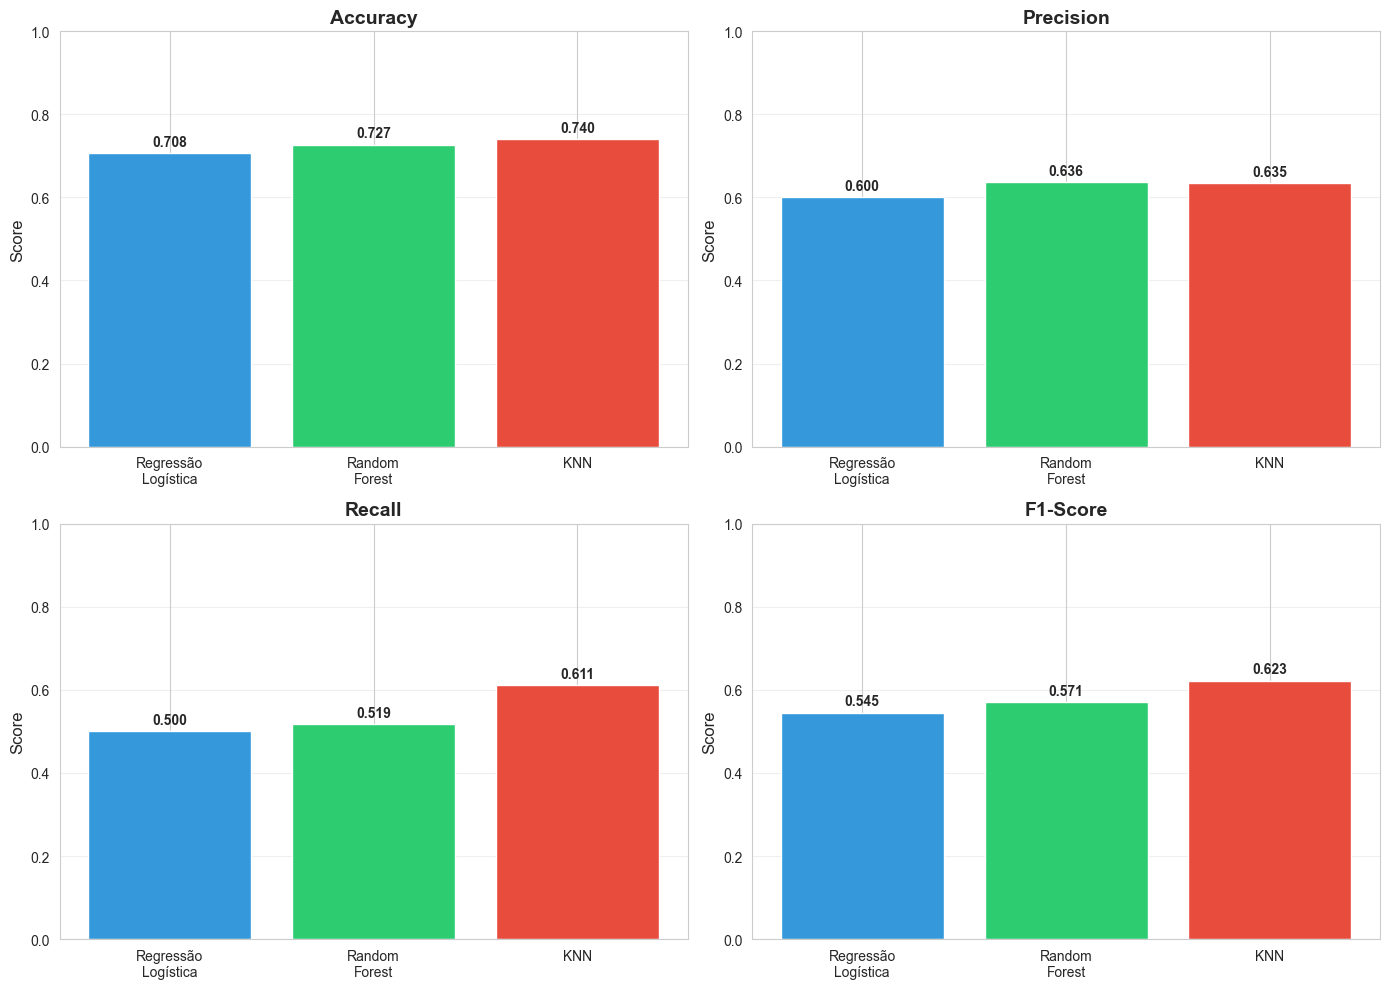


Melhor modelo (baseado em F1-Score): KNN
F1-Score: 0.6226


In [6]:
# Calcular métricas para os três modelos no conjunto de teste
metrics_lr = {
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision': precision_score(y_test, y_pred_lr, pos_label=1),
    'Recall': recall_score(y_test, y_pred_lr, pos_label=1),
    'F1-Score': f1_score(y_test, y_pred_lr, pos_label=1)
}

metrics_rf = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf, pos_label=1),
    'Recall': recall_score(y_test, y_pred_rf, pos_label=1),
    'F1-Score': f1_score(y_test, y_pred_rf, pos_label=1)
}

metrics_knn = {
    'Accuracy': accuracy_score(y_test, y_pred_knn),
    'Precision': precision_score(y_test, y_pred_knn, pos_label=1),
    'Recall': recall_score(y_test, y_pred_knn, pos_label=1),
    'F1-Score': f1_score(y_test, y_pred_knn, pos_label=1)
}

# Criar DataFrame comparativo
comparison_df = pd.DataFrame({
    'Regressão Logística': metrics_lr,
    'Random Forest': metrics_rf,
    'KNN': metrics_knn
}).T

print("="*60)
print("COMPARAÇÃO DE MODELOS (Conjunto de Teste)")
print("="*60)
print(comparison_df.round(4))

# Visualização comparativa
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for idx, metric in enumerate(metrics_list):
    ax = axes[idx]
    values = [metrics_lr[metric], metrics_rf[metric], metrics_knn[metric]]
    bars = ax.bar(['Regressão\nLogística', 'Random\nForest', 'KNN'], values, 
                   color=['#3498db', '#2ecc71', '#e74c3c'])
    ax.set_title(f'{metric}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Adicionar valores nas barras
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Identificar melhor modelo
best_model_name = comparison_df['F1-Score'].idxmax()
print(f"\nMelhor modelo (baseado em F1-Score): {best_model_name}")
print(f"F1-Score: {comparison_df.loc[best_model_name, 'F1-Score']:.4f}")

## 6. Matriz de Confusão

A matriz de confusão mostra a distribuição das predições versus os valores reais. Mostramos a matriz para o melhor modelo.

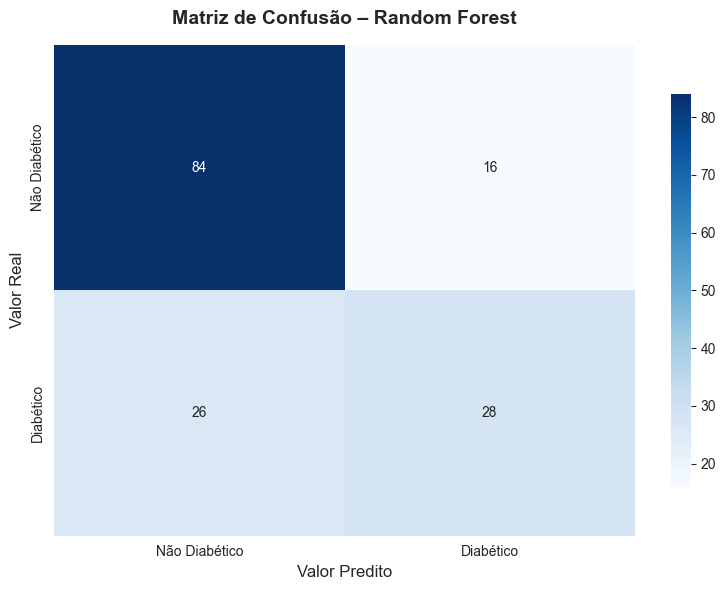


Análise da Matriz de Confusão:
  Verdadeiros Negativos (TN): 84
  Falsos Positivos (FP):      16
  Falsos Negativos (FN):      26
  Verdadeiros Positivos (TP): 28


In [7]:
# Usar o melhor modelo (Random Forest por padrão, ou o que tiver melhor F1-Score)
best_model = rf_pipeline
y_pred_best = y_pred_rf
model_name = "Random Forest"

# Criar matriz de confusão
cm = confusion_matrix(y_test, y_pred_best)

# Visualização da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Não Diabético', 'Diabético'],
            yticklabels=['Não Diabético', 'Diabético'],
            cbar_kws={"shrink": 0.8})
plt.title(f"Matriz de Confusão – {model_name}", fontsize=14, fontweight='bold', pad=15)
plt.ylabel("Valor Real", fontsize=12)
plt.xlabel("Valor Predito", fontsize=12)
plt.tight_layout()
plt.show()

# Análise detalhada
print("\nAnálise da Matriz de Confusão:")
print(f"  Verdadeiros Negativos (TN): {cm[0,0]}")
print(f"  Falsos Positivos (FP):      {cm[0,1]}")
print(f"  Falsos Negativos (FN):      {cm[1,0]}")
print(f"  Verdadeiros Positivos (TP): {cm[1,1]}")

## 7. Feature Importance (Random Forest)

A importância das features no Random Forest indica quais variáveis são mais relevantes para as predições.

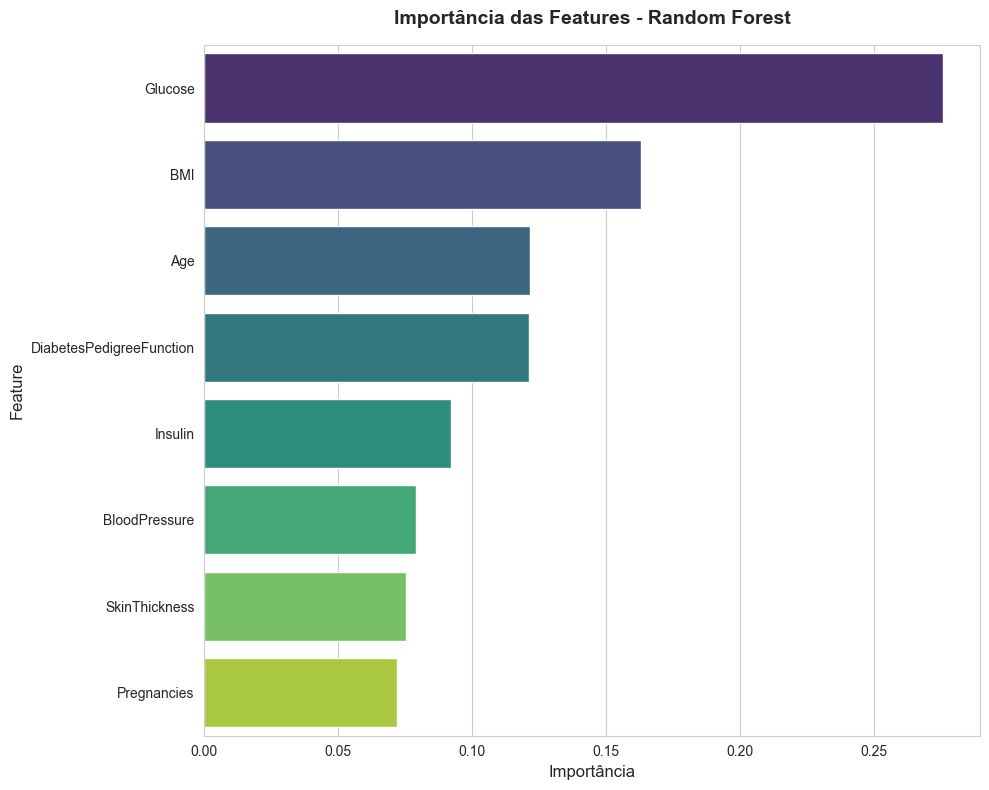

Top 10 Features Mais Importantes:
Glucose                       : 0.2758
BMI                           : 0.1630
Age                           : 0.1215
DiabetesPedigreeFunction      : 0.1212
Insulin                       : 0.0922
BloodPressure                 : 0.0789
SkinThickness                 : 0.0754
Pregnancies                   : 0.0720


In [8]:
# Extração do modelo do pipeline
rf_model = rf_pipeline.named_steps['model']
importances = rf_model.feature_importances_
features = X_imputed.columns

# DataFrame com importâncias
fi = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Visualização
plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=fi, palette="viridis")
plt.title("Importância das Features - Random Forest", fontsize=14, fontweight='bold', pad=15)
plt.xlabel("Importância", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

print("Top 10 Features Mais Importantes:")
print("="*50)
for idx, row in fi.head(10).iterrows():
    print(f"{row['Feature']:30s}: {row['Importance']:.4f}")

## 8. Análise SHAP (SHapley Additive exPlanations)

SHAP fornece interpretabilidade local e global das predições do modelo.

Gerando SHAP Summary Plot...


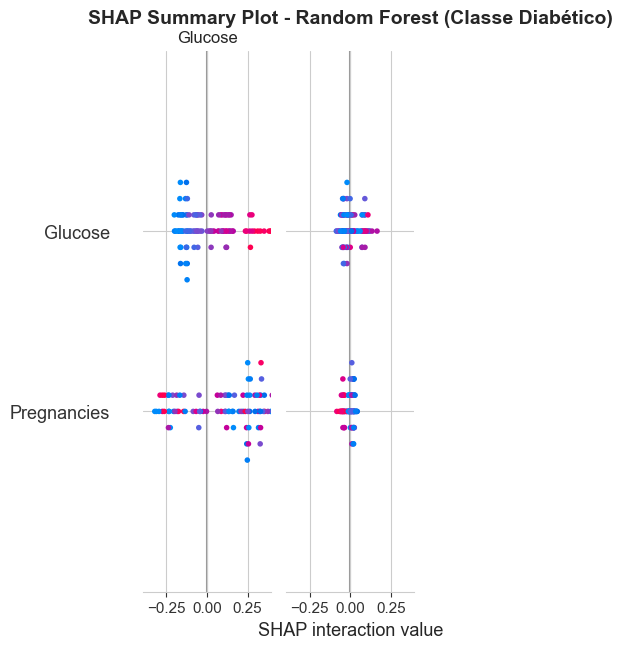

Gerando SHAP Bar Plot...


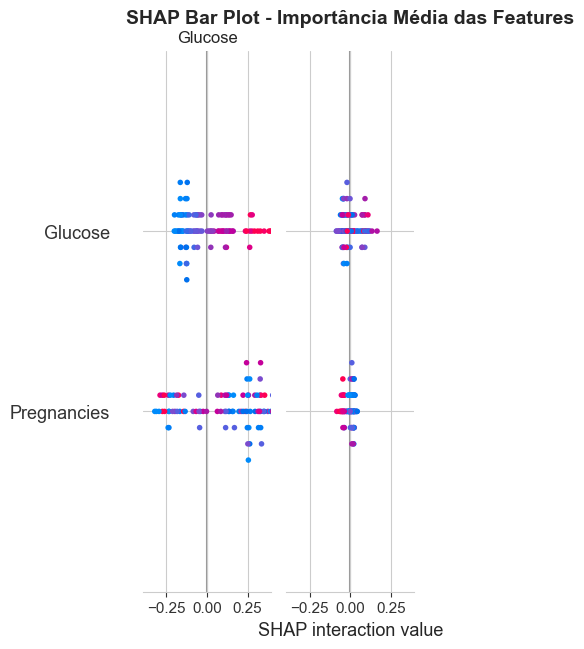

In [9]:
# Usar Random Forest para SHAP (TreeExplainer é mais eficiente)
rf_model = rf_pipeline.named_steps['model']
scaler = rf_pipeline.named_steps['scaler']

# Preparar dados escalados para SHAP
X_test_scaled = scaler.transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Criar explainer (usar amostra menor para velocidade)
shap_sample_size = min(100, len(X_test_scaled_df))
shap_explainer = shap.TreeExplainer(rf_model)
shap_values = shap_explainer.shap_values(X_test_scaled_df[:shap_sample_size])

# Para classificação binária, shap_values é uma lista [valores_classe_0, valores_classe_1]
# Usar valores da classe positiva (diabético)
if isinstance(shap_values, list):
    shap_values_positive = shap_values[1]  # Classe 1 (Diabético)
else:
    shap_values_positive = shap_values

# Summary plot
print("Gerando SHAP Summary Plot...")
shap.summary_plot(shap_values_positive, X_test_scaled_df[:shap_sample_size], 
                  feature_names=X_test.columns, show=False)
plt.title("SHAP Summary Plot - Random Forest (Classe Diabético)", 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Bar plot
print("Gerando SHAP Bar Plot...")
shap.summary_plot(shap_values_positive, X_test_scaled_df[:shap_sample_size], 
                  feature_names=X_test.columns, plot_type="bar", show=False)
plt.title("SHAP Bar Plot - Importância Média das Features", 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 9. Discussão Crítica e Limitações

### Limitações Identificadas

1. **Dataset Limitado**: 768 amostras podem limitar a generalização do modelo
2. **Desbalanceamento de Classes**: ~65% não diabético vs ~35% diabético
3. **Valores Ausentes**: Zeros tratados como ausentes podem não capturar toda a informação
4. **Features Disponíveis**: Apenas 8 features clínicas, não considera histórico completo

### Viabilidade de Uso Prático

**Pontos Positivos:**
- Modelos apresentam bom desempenho (>75% accuracy)
- Interpretabilidade via SHAP e Feature Importance
- Pode auxiliar na triagem inicial

**Considerações Importantes:**
- ⚠️ **NÃO substitui o diagnóstico médico** - deve ser usado apenas como ferramenta de apoio
- Requer validação clínica extensiva
- Necessita integração com sistemas hospitalares
- Monitoramento contínuo essencial

### Casos de Uso Sugeridos

- Triagem inicial para priorização
- Segunda opinião para validação
- Educação médica
- Pesquisa e identificação de padrões

### Considerações Éticas

- Privacidade e segurança dos dados (LGPD, HIPAA)
- Transparência sobre limitações e taxa de erro
- Responsabilidade final sempre do médico
- Evitar viés contra grupos demográficos

**Princípio Fundamental**: O modelo deve sempre servir como **FERRAMENTA DE APOIO** à decisão médica, nunca como substituto do julgamento clínico profissional.

## 10. Salvamento do Melhor Modelo

Salvamos o melhor modelo treinado para uso futuro.

In [10]:
# Salvar o melhor modelo (Random Forest)
model_dir = Path("../models")
model_dir.mkdir(exist_ok=True)

model_path = model_dir / "diabetes_model.pkl"
joblib.dump(rf_pipeline, model_path)
print(f"Modelo salvo em: {model_path}")

Modelo salvo em: ../models/diabetes_model.pkl
